In [1]:
using Distributions
using StaticArrays: SMatrix, SVector
using Plots
using LinearAlgebra

In [2]:
import KalmanFilterTools: KalmanFilterState, KalmanFilter

┌ Info: Precompiling KalmanFilterTools [b4cd1eb8-1e24-11e8-3319-93036a3eb9f3]
└ @ Base loading.jl:1260
┌ Warning: Package KalmanFilterTools does not have LinearAlgebra in its dependencies:
│ - If you have KalmanFilterTools checked out for development and have
│   added LinearAlgebra as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with KalmanFilterTools
└ Loading LinearAlgebra into KalmanFilterTools from project dependency, future warnings for KalmanFilterTools are suppressed.


# Random acceleration Kalman filter

## Generate data

In [3]:
struct RandomMotionParameters{T<:AbstractFloat}
    motion_noise::T
    measurement_noise::T
    initial_state::SVector{2, T}
end

In [4]:
function generate_data(point_count, parameters::RandomMotionParameters{T}, time_delta::T) where {T}
    state = parameters.initial_state
    motion_distribution = Normal(0, parameters.motion_noise)
    measurement_distribution = Normal(0, parameters.measurement_noise)
    measurements = SVector{1, T}[]
    states = SVector{2, T}[]
    for _ in 1:point_count
        acceleration = rand(motion_distribution)
        state = SVector{2}(state[1] + state[2] * time_delta + acceleration * time_delta * time_delta / 2,
         state[2] + acceleration * time_delta)
        measurement = SVector{1}(state[1] + rand(measurement_distribution))
        push!(measurements, measurement)
        push!(states, state)
    end
    measurements, states
end

generate_data (generic function with 1 method)

## Plot data

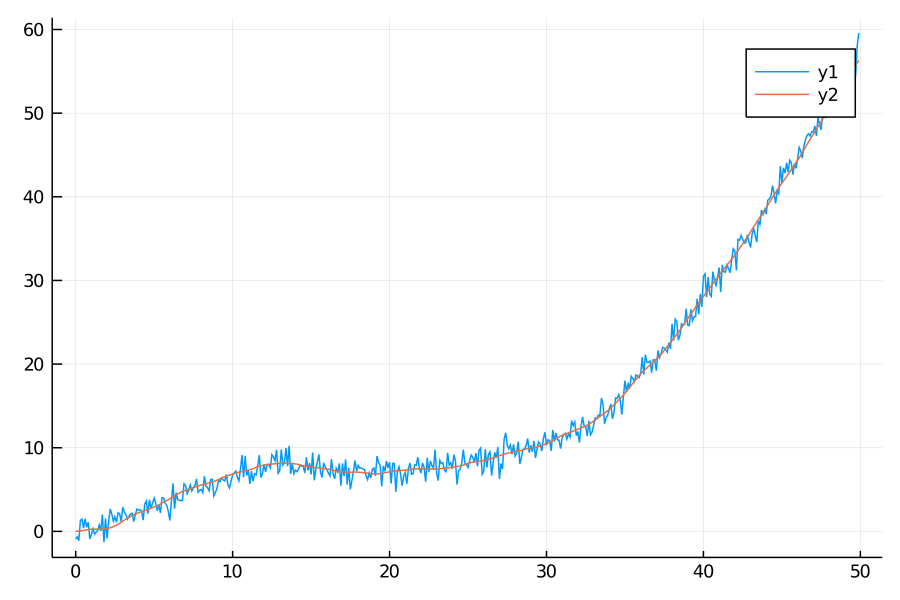

In [5]:
time_delta = 0.1
points_count = 500
times = Array{Float64}(0:points_count - 1) * time_delta
measurements, states = generate_data(points_count, RandomMotionParameters(1., 1., SVector{2}(0., 0.)), time_delta)
plt = plot(times, [measurement[1] for measurement in measurements], dpi=150)
plot!(plt, times, [state[1] for state in states])

## filter data

In [6]:
struct RandomAccelerationFilter{T}
    motion_noise::T
    measurement_noise::T
end
struct RandomMotionFilter{T}
    motion_noise::T
    measurement_noise::T
end

In [7]:
function KalmanFilter(self::RandomAccelerationFilter, time_delta)
    motion_model = SMatrix{2, 2}(1, 0, time_delta, 1)
    measurement_model = SMatrix{1, 2}(1., 0.)
    measurement_error_model = SMatrix{1, 1}(self.measurement_noise ^ 2)
    state_motion_error_model = SMatrix{2, 1}(time_delta ^ 2 / 2, time_delta)
    motion_error_model = state_motion_error_model * transpose(state_motion_error_model) * self.motion_noise ^ 2
    KalmanFilter(motion_model, motion_error_model, measurement_model, measurement_error_model)
end
function KalmanFilter(self::RandomMotionFilter, time_delta)
    motion_model = SMatrix{1, 1}(1.)
    measurement_model = SMatrix{1, 1}(1.)
    measurement_error_model = SMatrix{1}(self.measurement_noise ^ 2)
    motion_error_model = SMatrix{1}(self.motion_noise ^ 2 * time_delta ^ 2)
    KalmanFilter(motion_model, motion_error_model, measurement_model, measurement_error_model)
end

KalmanFilter

In [8]:
inital_state = KalmanFilterState(SVector(0., 0.), SMatrix{2,2}(0.13, 0.09, 0.09, 0.13))
filter_object = KalmanFilter(RandomAccelerationFilter(1., 1.), time_delta)
result = filter(filter_object, measurements, inital_state);

In [9]:
result[500].covariance

2×2 StaticArrays.SArray{Tuple{2,2},Float64,2,4} with indices SOneTo(2)×SOneTo(2):
 0.131851   0.0931745
 0.0931745  0.13651

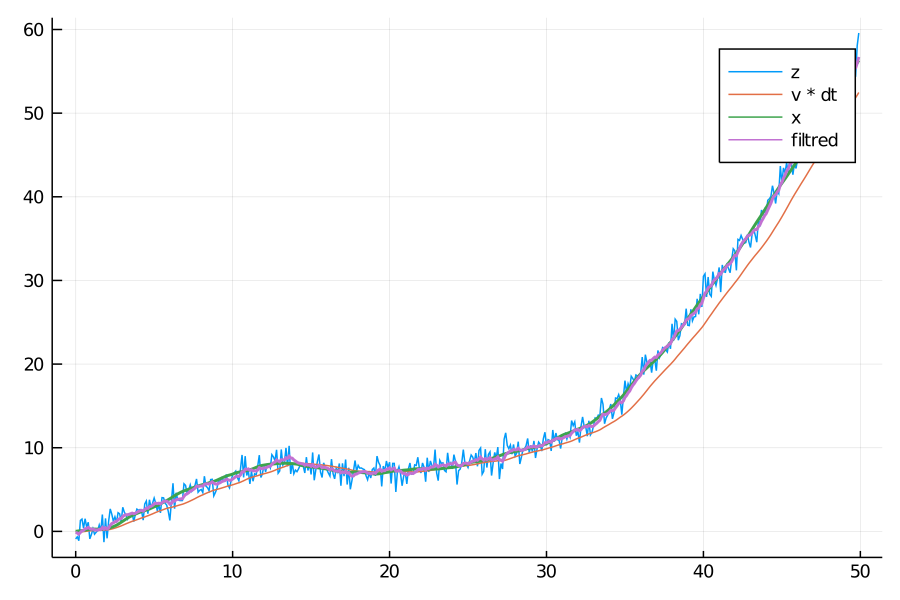

In [10]:
plt = plot(times, [measurement[1] for measurement in measurements], label="z", dpi=150)
intergrated_velocities = cumsum([state.state[2] for state in result]) * time_delta
plot!(plt, times, intergrated_velocities, label="v * dt")
plot!(plt, times, [state[1] for state in states], label="x", lw=2)
plot!(plt, times, [state.state[1] for state in result], label="filtred", lw=2)

## Filter velocity

In [11]:
velocities = (measurements - circshift(measurements, 1)) / time_delta
velocities[1] = SVector(0.)

1-element StaticArrays.SArray{Tuple{1},Float64,1,1} with indices SOneTo(1):
 0.0

In [12]:
inital_state = KalmanFilterState(SVector(0.), SMatrix{1,1}(4.5))
filter_object = KalmanFilter(RandomMotionFilter(7., 5.), time_delta)
filtred_velocities = filter(filter_object, velocities, inital_state);

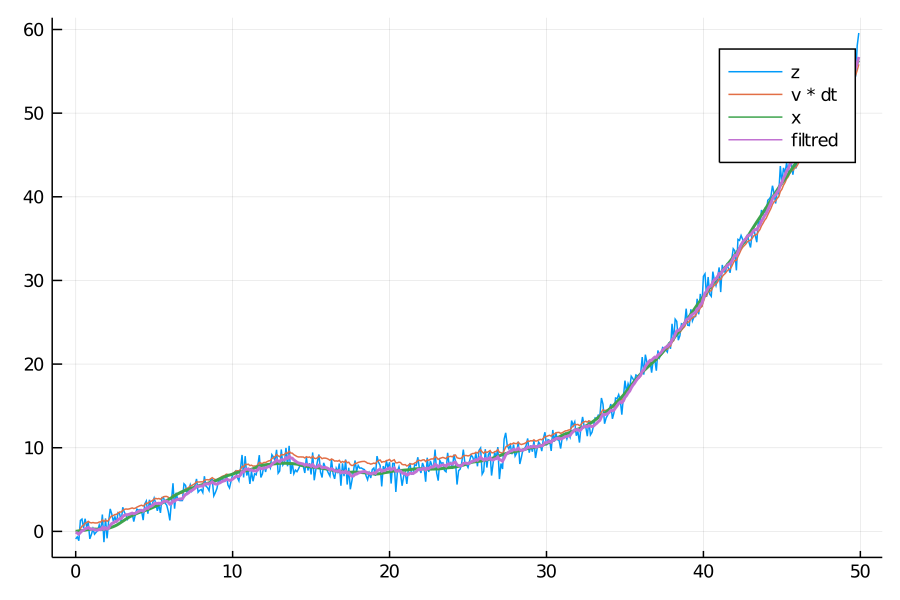

In [13]:
plt = plot(times, [measurement[1] for measurement in measurements], label="z", dpi=150)
intergrated_velocities = cumsum([state.state[1] for state in filtred_velocities]) * time_delta
plot!(plt, times, intergrated_velocities, label="v * dt")
plot!(plt, times, [state[1] for state in states], label="x", lw=2)
plot!(plt, times, [state.state[1] for state in result], label="filtred", lw=2)

# Kalman filter with measurement with bias

## Generate data

In [14]:
struct BiasMeasurementParameters{T<:AbstractFloat}
    motion_noise::T
    first_measurement_noise::T
    second_measurement_noise::T
    bias_noise::T
end

In [15]:
function generate_data(point_count, parameters::BiasMeasurementParameters{T}, 
        time_delta::T, initial_state::SVector{3, T}) where {T}
    state = initial_state
    motion_distribution = Normal(0, parameters.motion_noise)
    first_measurement_distribution = Normal(0, parameters.first_measurement_noise)
    second_measurement_distribution = Normal(0, parameters.second_measurement_noise)
    bias_distribution = Normal(0, parameters.bias_noise)
    measurements = SVector{2, T}[]
    states = SVector{3, T}[]
    for _ in 1:point_count
        acceleration = rand(motion_distribution)
        state = SVector{3}(state[1] + state[2] * time_delta + acceleration * time_delta * time_delta / 2,
                           state[2] + acceleration * time_delta,
                           state[3] + rand(bias_distribution) * time_delta)
        measurement = SVector{2}(state[1] + rand(first_measurement_distribution),
                                 state[1] + state[3] + rand(second_measurement_distribution))
        push!(measurements, measurement)
        push!(states, state)
    end
    measurements, states
end

generate_data (generic function with 2 methods)

## Plot data

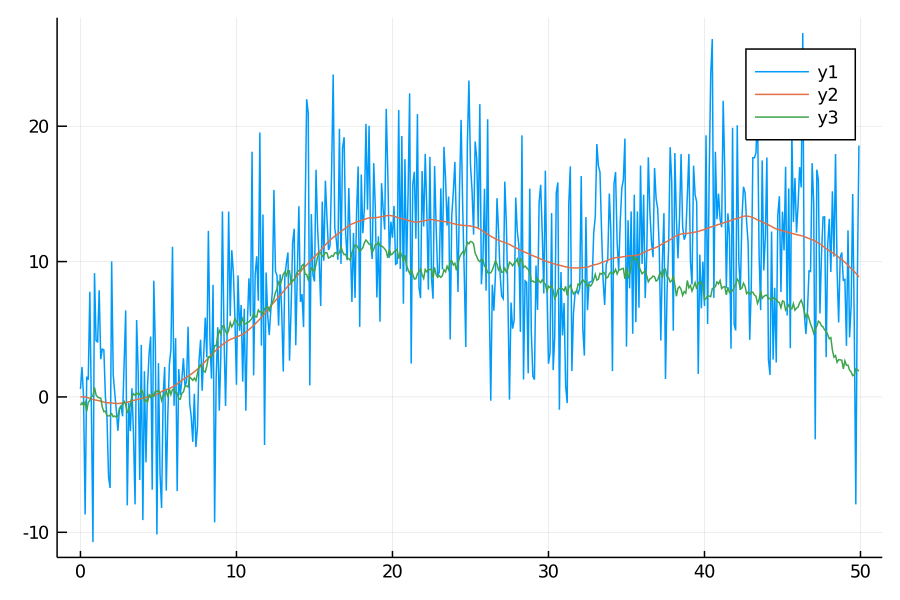

In [16]:
time_delta = 0.1
points_count = 500
times = Array{Float64}(0:points_count - 1) * time_delta
measurements, states = generate_data(points_count, BiasMeasurementParameters(1., 5., 0.1, 3.), 
    time_delta, SVector{3}(0., 0., 0.))
plt = plot(times, [measurement[1] for measurement in measurements], dpi=150)
plot!(plt, times, [state[1] for state in states])
plot!(plt, times, [measurement[2] for measurement in measurements])

## Filter by random acceleration filter

In [17]:
inital_state = KalmanFilterState(SVector(0., 0.), SMatrix{2,2}(1, 0, 0, 1.))
filter_object = KalmanFilter(RandomAccelerationFilter(1., 5.), time_delta)
random_acceleration_result = filter(filter_object, [SVector{1}(x[1]) for x in measurements], inital_state);

In [31]:
function rmse(prediction::Array{T}, target::Array{T}) where {T}
    sqrt(mean((prediction - target) .^ 2))
end

rmse (generic function with 1 method)

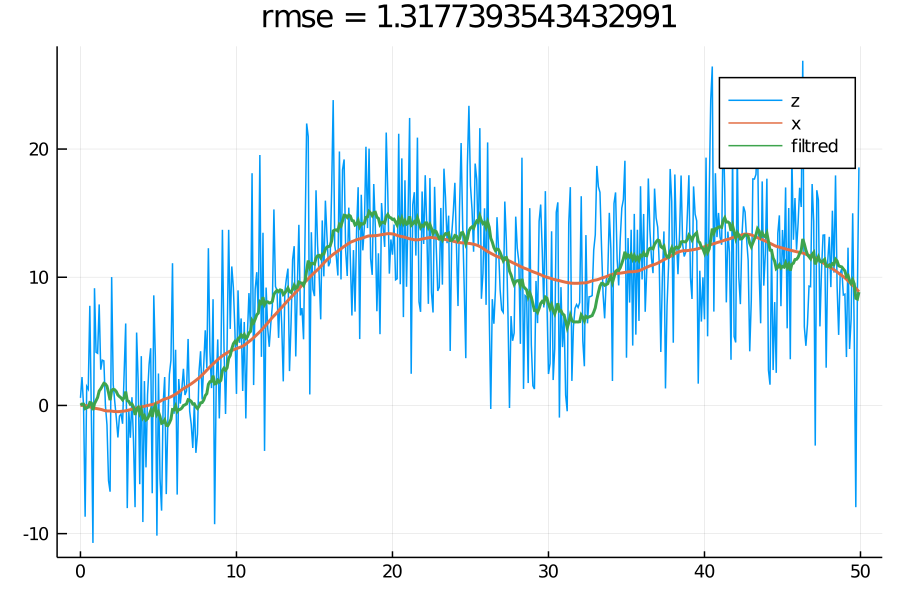

In [32]:
result = random_acceleration_result
title = "rmse = " * string(rmse([state[1] for state in states], [state.state[1] for state in result]))
plt = plot(times, [measurement[1] for measurement in measurements], label="z", dpi=150, title=title)
plot!(plt, times, [state[1] for state in states], label="x", lw=2)
plot!(plt, times, [state.state[1] for state in result], label="filtred", lw=2)

In [20]:
rmse([state[1] for state in states], [state.state[1] for state in random_acceleration_result])

1.3177393543432991

## Simple filter

In [21]:
inital_state = KalmanFilterState(SVector(0.), SMatrix{1,1}(1.))
filter_object = KalmanFilter(RandomMotionFilter(10., 5.), time_delta)
random_motion_result = filter(filter_object, [SVector{1}(x[1]) for x in measurements], inital_state);

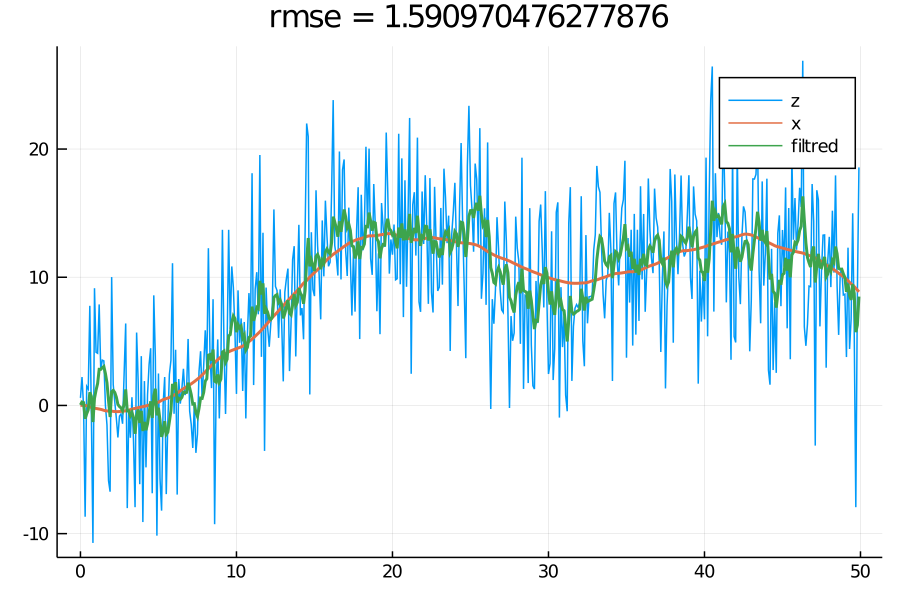

In [22]:
result = random_motion_result
title = "rmse = " * string(rmse([state[1] for state in states], [state.state[1] for state in result]))
plt = plot(times, [measurement[1] for measurement in measurements], label="z", dpi=150, title=title)
plot!(plt, times, [state[1] for state in states], label="x", lw=2)
plot!(plt, times, [state.state[1] for state in result], label="filtred", lw=2)

## Simple filter with bias

In [23]:
struct BiasRandomMotionFilter{T}
    motion_noise::T
    first_measurement_noise::T
    second_measurement_noise::T
    bias_noise::T
end

In [24]:
function KalmanFilter(self::BiasRandomMotionFilter, time_delta)
    motion_model = SMatrix{2, 2}(1., 0., 0., 1.)
    measurement_model = SMatrix{2, 2}(1., 1., 0., 1.)
    measurement_error_model = SMatrix{2, 2}(self.first_measurement_noise ^ 2, 0, 0, self.second_measurement_noise ^ 2)
    motion_error_model = SMatrix{2, 2}(self.motion_noise ^ 2 * time_delta ^ 2, 0, 0, 
        self.bias_noise ^ 2 * time_delta ^ 2)
    KalmanFilter(motion_model, motion_error_model, measurement_model, measurement_error_model)
end

KalmanFilter

In [25]:
inital_state = KalmanFilterState(SVector(0., 0.), SMatrix{2, 2}(1., 0., 0., 1.))
filter_object = KalmanFilter(BiasRandomMotionFilter(10., 5., 0.1, 2.), time_delta)
random_bias_motion_result = filter(filter_object, measurements, inital_state);

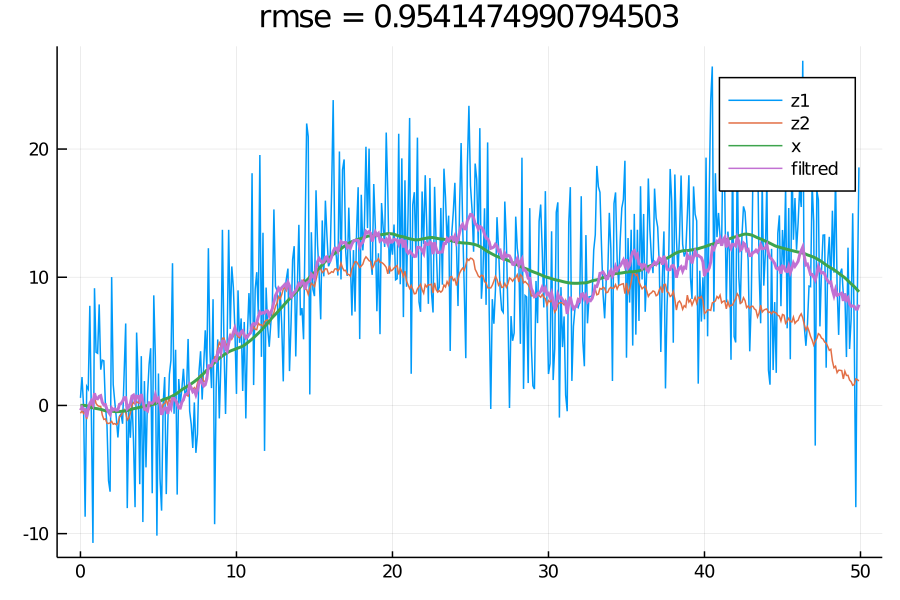

In [26]:
result = random_bias_motion_result
title = "rmse = " * string(rmse([state[1] for state in states], [state.state[1] for state in result]))
plt = plot(times, [measurement[1] for measurement in measurements], label="z1", dpi=150, title=title)
plot!(plt, times, [measurement[2] for measurement in measurements], label="z2")
plot!(plt, times, [state[1] for state in states], label="x", lw=2)
plot!(plt, times, [state.state[1] for state in result], label="filtred", lw=2)

## Random acceleration filter with bias

In [27]:
struct BiasRandomAccelerationFilter{T}
    motion_noise::T
    first_measurement_noise::T
    second_measurement_noise::T
    bias_noise::T
end

In [28]:
function KalmanFilter(self::BiasRandomAccelerationFilter, time_delta)
    motion_model = SMatrix{3, 3}(1., 0., 0., time_delta, 1., 0., 0, 0, 1.)
    measurement_model = SMatrix{2, 3}(1., 1., 0., 0., 0., 1.)
    measurement_error_model = SMatrix{2, 2}(self.first_measurement_noise ^ 2, 0, 0, self.second_measurement_noise ^ 2)
    motion_error_model = 1.0 * zeros(3, 3)
    state_motion_error_model = SMatrix{2, 1}(time_delta ^ 2 / 2, time_delta)
    motion_error_model[1:2, 1:2] .= state_motion_error_model * 
        transpose(state_motion_error_model) * self.motion_noise ^ 2
    motion_error_model[3, 3] = self.bias_noise ^ 2 * time_delta ^ 2
    KalmanFilter(motion_model, SMatrix{3, 3}(motion_error_model), measurement_model, measurement_error_model)
end

KalmanFilter

In [29]:
inital_state = KalmanFilterState(SVector(0., 0., 0.), SMatrix{3, 3}(1.0I))
filter_object = KalmanFilter(BiasRandomAccelerationFilter(1., 5., 0.1, 3.), time_delta)
random_bias_acceleration_result = filter(filter_object, measurements, inital_state);

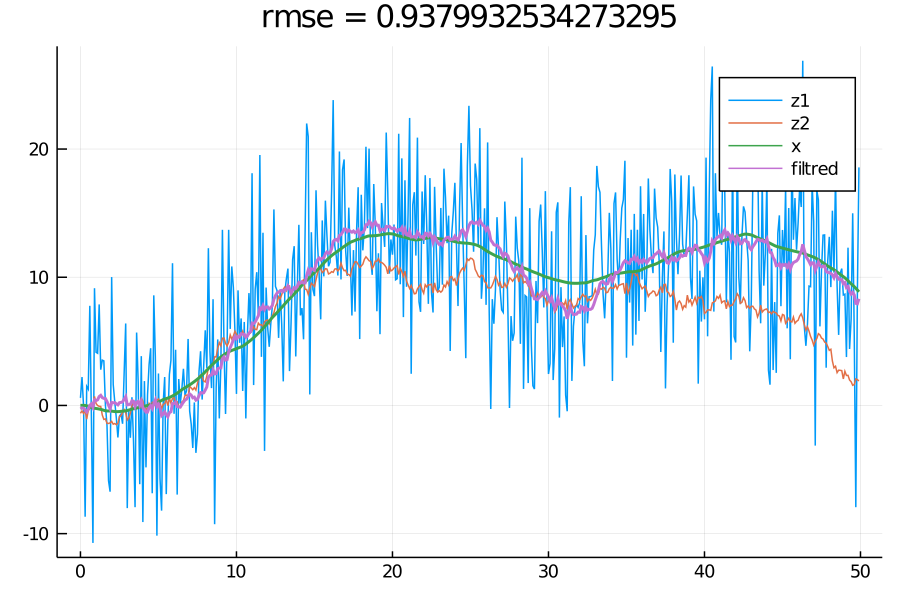

In [30]:
result = random_bias_acceleration_result
title = "rmse = " * string(rmse([state[1] for state in states], [state.state[1] for state in result]))
plt = plot(times, [measurement[1] for measurement in measurements], label="z1", dpi=150, title=title)
plot!(plt, times, [measurement[2] for measurement in measurements], label="z2")
plot!(plt, times, [state[1] for state in states], label="x", lw=2)
plot!(plt, times, [state.state[1] for state in result], label="filtred", lw=2)